In [1]:
# Merge all recorded data

from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import helper_functions
%matplotlib inline


pd.set_option('mode.chained_assignment', None)

# Set up figure size and DPI for screen demo
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 150


# DL1	Stone Garden - Tjaden Hall
# DL2	PSB Parking Lot
# DL3	Olin Library
# DL4	Milstein Hall Roof
# DL5	Game Farm Road


S1 = HoboReader("DL1_Stone_Garden_Tjaden_Hall.csv")
S2 = HoboReader("DL2_PSB_Parking_Lot.csv")
S3 = HoboReader("DL3_Olin_Library.csv")
S4 = HoboReader("DL4_Milstein_Hall_Roof.csv")
S5 = HoboReader("DL5_Game_Farm_Road_20192020v5.csv")


df1 = S1.get_dataframe()
df2 = S2.get_dataframe()
df3 = S3.get_dataframe()
df4 = S4.get_dataframe()
df5 = S5.get_dataframe()

# DF5 (GAME FARM ROAD) HAS TO BE SHIFTED BACK BECAUSE IT NATIVELY RECORDS DST, OUR STATIONS DO NOT.
# THE OTHER STATIONS ARE NOT SHIFTED (HENCE 0 VALUE FOR PERIODS), JUST THERE FOR SANITY

df5 = df5.shift(periods=(-2), fill_value=0)
df4 = df4.shift(periods=(0), fill_value=0)
df3 = df3.shift(periods=(0), fill_value=0)
df2 = df2.shift(periods=(0), fill_value=0)
df1 = df1.shift(periods=(0), fill_value=0)

# CONVERT IMPERIAL TO METRIC UNITS REMOVED 9/3 - all data natively in METRIC

title,#,Date Time,Pressure,Temp,RH,Solar Radiation,MRT,Wind Speed,Gust Speed,Wind Direction,DewPt
timezone_str,NaN,GMT-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,NaN,NaN,in Hg,Â°C,%,W/mÂ²,Â°c,m/s,m/S,Ã¸,Â°C
logger_serial_number,NaN,NaN,20098500,20098500,20098500,20098500,20098500,20098500,20098500,20098500,20098500
sensor_serial_number,NaN,NaN,10751992,10763331,10763331,10775592,20496099,20706789,20706789,20706789,10763331
datetimes,,,,,,,,,,,
2019-09-17 17:37:26-05:00,1,09/17/19 05:37:26 PM,29.3395,19.673889,59.9,5.6,19.936111,1.00137,2.668829,328.0,11.722222
2019-09-17 17:47:26-05:00,2,09/17/19 05:47:26 PM,29.3395,19.483889,53.6,4.4,19.388889,1.00137,2.338019,5.6,9.777778
2019-09-17 17:57:26-05:00,3,09/17/19 05:57:26 PM,29.3454,19.127222,52.0,1.9,18.888889,1.00137,1.671930,4.2,9.111111
2019-09-17 18:07:26-05:00,4,09/17/19 06:07:26 PM,29.3513,18.793889,53.4,0.6,18.461111,0.67056,1.998269,1.4,9.111111
2019-09-17 18:17:26-05:00,5,09/17/19 06:17:26 PM,29.3543,18.508889,54.0,0.6,18.105000,1.00137,2.338019,1.4,9.000000


interactive(children=(IntSlider(value=4, description='variable_id', max=8, min=1), IntSlider(value=15, descrip…

<function __main__.f(variable_id, period_len, day, resample_len, month, year)>

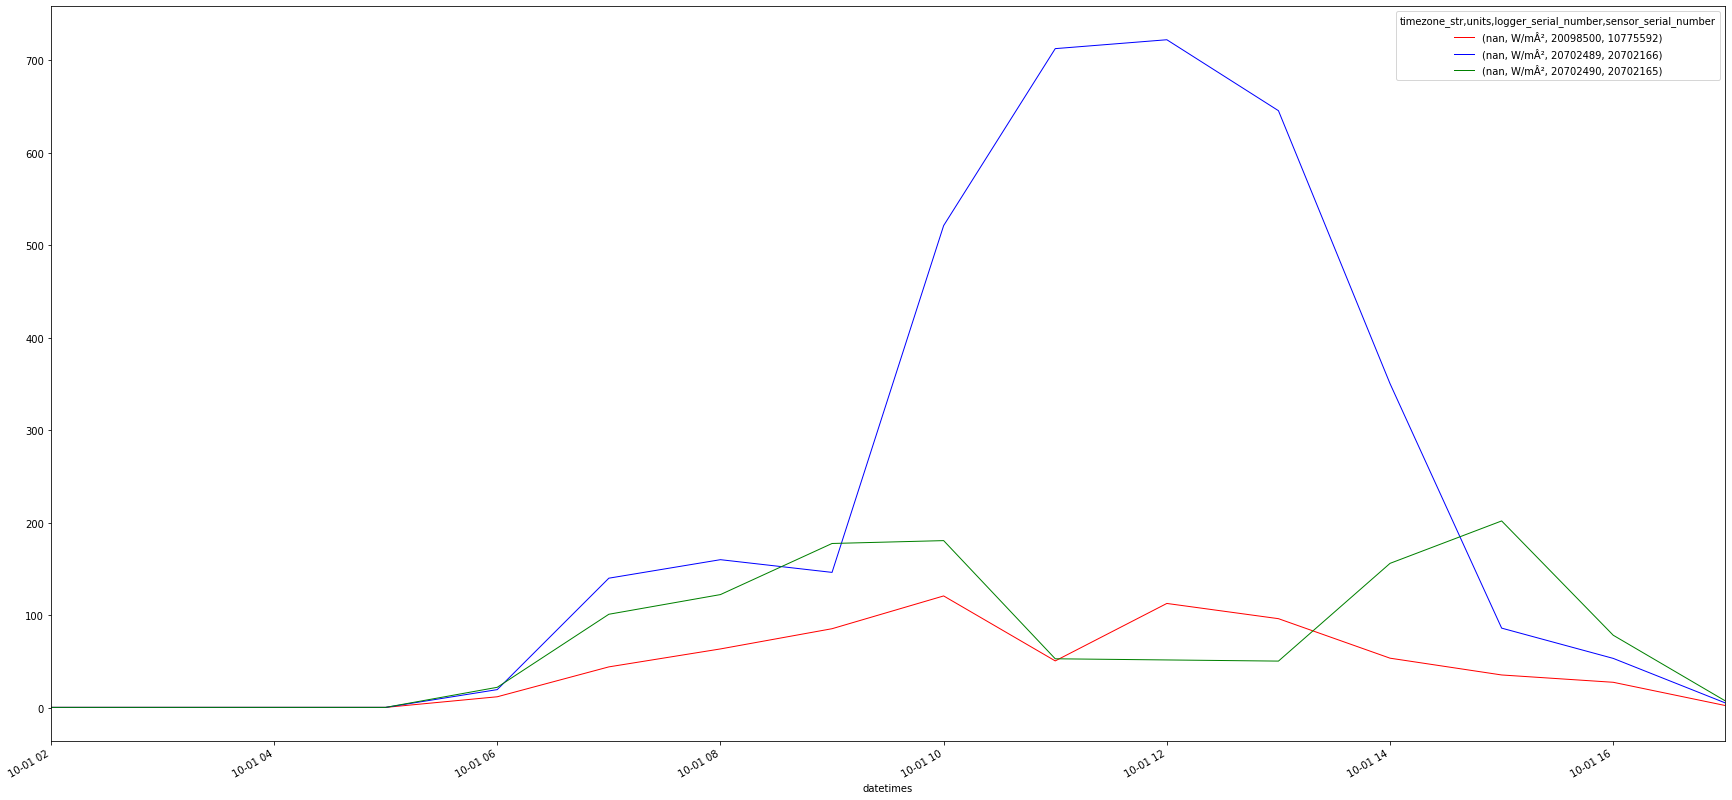

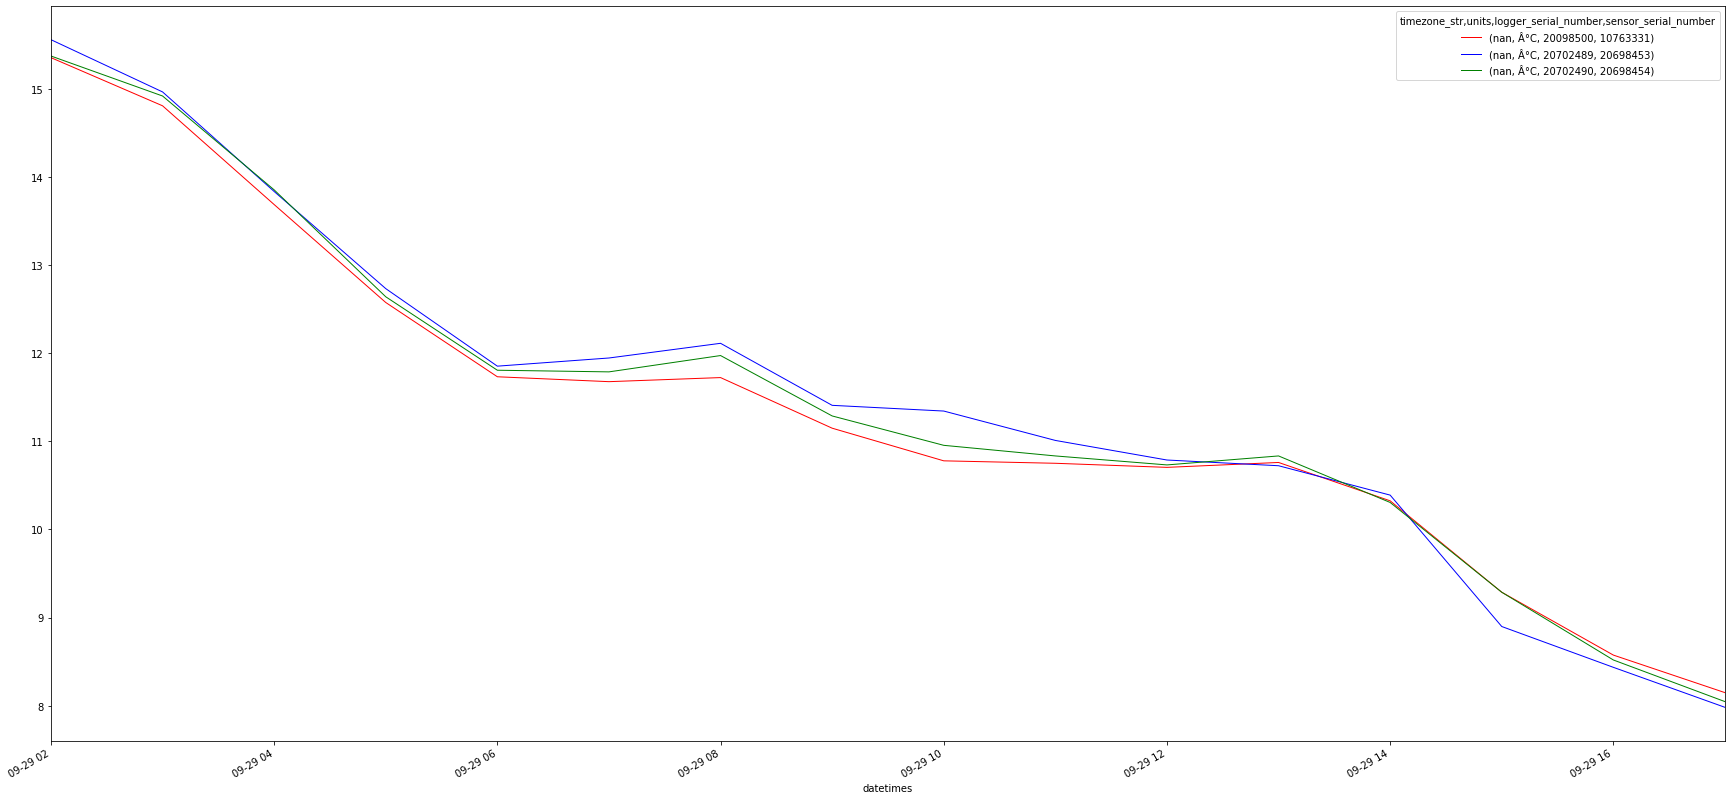

In [5]:
def f(variable_id, period_len, day, resample_len, month, year):
    
    start_time = str(year) + '-' + str(month) + '-' + str(        day) + ' 07:00:00-00:00'
    end_time = str(year) + '-' + str(month) + '-' + str(day+period_len-1) + ' 23:00:00-00:00'
    
    df1_ = df1.loc[start_time:end_time]
    df2_ = df2.loc[start_time:end_time]
    df3_ = df3.loc[start_time:end_time]
    df4_ = df4.loc[start_time:end_time]
    df5_ = df5.loc[start_time:end_time]
    
#Resample subhourly data to 1 hourly graph (OUR STATIONS RECORD IN 10MIN INTERVALS, GFR IN 1HR, RESAMPLE FOR EASY COMPARISON. CAN TURN OFF)
    df1_ = df1_.resample(str(resample_len) + 'H').mean()
    df2_ = df2_.resample(str(resample_len) + 'H').mean()
    df3_ = df3_.resample(str(resample_len) + 'H').mean()
    df4_ = df4_.resample(str(resample_len) + 'H').mean()
    df5_ = df5_.resample(str(resample_len) + 'H').mean()
    
    # Translate to °C - REMOVED 9/3 - all data natively in METRIC

    #df1_["Temp"] = df1_["Temp"].apply(lambda x: ftoc(x), axis=1)
    #df2_["Temp"] = df2_["Temp"].apply(lambda x: ftoc(x), axis=1)
    #df3_["Temp"] = df3_["Temp"].apply(lambda x: ftoc(x), axis=1)
    #df4_["Temp"] = df4_["Temp"].apply(lambda x: ftoc(x), axis=1)

    #df1_["MRT"] = df1_["MRT"].apply(lambda x: ftoc(x), axis=1)
    #df2_["MRT"] = df2_["MRT"].apply(lambda x: ftoc(x), axis=1)
    #df3_["MRT"] = df3_["MRT"].apply(lambda x: ftoc(x), axis=1)
    #df4_["MRT"] = df4_["MRT"].apply(lambda x: ftoc(x), axis=1)

    # Translate to m/s

    #df1_["Wind Speed"] = df1_["Wind Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df2_["Wind Speed"] = df2_["Wind Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df3_["Wind Speed"] = df3_["Wind Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df4_["Wind Speed"] = df4_["Wind Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df5_["Wind Speed"] = df5_["Wind Speed"].apply(lambda x: mphtoms(x), axis=1)

    #df1_["Gust Speed"] = df1_["Gust Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df2_["Gust Speed"] = df2_["Gust Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df3_["Gust Speed"] = df3_["Gust Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df4_["Gust Speed"] = df4_["Gust Speed"].apply(lambda x: mphtoms(x), axis=1)
    #df5_["Gust Speed"] = df5_["Gust Speed"].apply(lambda x: mphtoms(x), axis=1)

    # df1.index

    # Print Headers
    # print(df1.columns.values)

    # Resize figure
    custom_figsize = (30, 15)

    # Change lineweights
    lineweights = 1.5

    variables = [
        "Wind Speed", "MRT", "Temp", "RH", "Solar Radiation", "Wind Speed",
        "Gust Speed", "Wind Direction", "DewPt"
    ]

    variable = variables[variable_id]

    # Plot both temp and mrt when temp is selected

    if variable == "MRT" or variable == "DewPt" or variable == "Gust Speed":
        ax = df1_.plot(y=variable, lw=1, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=3.5,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

    elif variable == "Temp":
        # Plot two dataframes into one plot
        ax = df1_.plot(y=variable, lw=2, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=3.5,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

        ax = df1_.plot(y="MRT",
                       lw=1,
                       figsize=custom_figsize,
                       style=['--'],
                       color='red',
                       ax=ax)
        df2_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='blue',
                  ax=ax)
        df3_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='green',
                  ax=ax)
        df4_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='aqua',
                  ax=ax)

    else:
        # Plot two dataframes into one plot
        ax = df1_.plot(y=variable, lw=1, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

    # Legend
    ax.legend([
        "DL1 - Stone Garden - Tjaden Hall", "DL2 - PSB Parking Lot",
        "DL3 - Olin Library", "DL4 - Milstein Hall Roof ",
        "DL5 - Game Farm Road"
    ],
              loc='upper left',
              frameon=False,fontsize=20)

    # Fix xticks

    #years = mdates.YearLocator()  # every year
    #months = mdates.MonthLocator()  # every month
    #days = mdates.DayLocator()  # every day
    
    #minutes = mdates.MinuteLocator()  # every minute

    #days_fmt = mdates.DateFormatter('%d')
    
    

    # format the ticks
    if period_len > 1:
        hours = mdates.HourLocator(interval = 6)  # every 6 hours
        hours_fmt = mdates.DateFormatter('%H:00')
        ax.xaxis.set_major_locator(hours)    
        ax.xaxis.set_major_formatter(hours_fmt)
        

    else:
        hours = mdates.HourLocator()  # every 6 hours
        hours_fmt = mdates.DateFormatter('%H:00')       
        
        ax.xaxis.set_major_locator(hours)    
        ax.xaxis.set_major_formatter(hours_fmt)
        
    # we dont have minor ticks for now
    #ax.xaxis.set_minor_locator(hours)
    #ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    

 
          

    # Labels
    plt.ylabel(variable, fontname="Consolas", fontsize=26)
    plt.xlabel("UTC Time", fontname="Consolas", fontsize=26)
    

    # Title
    ax.set_title(str(
        start_time.split(' ')[0] + " "
        'to'
        " " + end_time.split(' ')[0] + " " + variable),
                 fontname="Consolas",
                 fontsize=28)

    # Save PDF
    plot_graph(plt, start_time, variable)


# Variable to plot
# 1 = "MRT °C"
# 2 = "Temp °C"
# 3 = "RH"
# 4 = "Solar Radiation"
# 5 = "Wind Speed"
# 6 = "Gust Speed"
# 7 = "Wind Direction"
# 8 = "DewPt"

interact(f,  variable_id=(1, 8, 1),period_len=(1,30,1), resample_len=(1,24,1), day=(1, 31, 1), month=(1, 12, 1), year=(2019, 2021, 1))

In [34]:
#PRINT RESAMPLED DATA (HOURLY) TO A .CSV FOR EPW FILE

from pprint import pprint
import pandas as pd


S1 = HoboReader("DL1_Stone_Garden_Tjaden_Hall.csv")
S2 = HoboReader("DL2_PSB_Parking_Lot.csv")
S3 = HoboReader("DL3_Olin_Library.csv")
S4 = HoboReader("DL4_Milstein_Hall_Roof.csv")

df1 = S1.get_dataframe()
df2 = S2.get_dataframe()
df3 = S3.get_dataframe()
df4 = S4.get_dataframe()


df1 = df1.resample('H').mean()
df2 = df2.resample('H').mean()
df3 = df3.resample('H').mean()
df4 = df4.resample('H').mean()

display(df1)
display(df2)
display(df3)
display(df4)


print(df1)
print(df2)
print(df3)
print(df4)



df1.to_csv('DL1_TJADEN_hourly.csv')
df2.to_csv('DL2_PSB_hourly.csv')
df3.to_csv('DL3_OLIN_hourly.csv')
df4.to_csv('DL4_MILSTEIN_hourly.csv')




title,Pressure,Temp,RH,Solar Radiation,MRT,Wind Speed,Gust Speed,Wind Direction,DewPt
timezone_str,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,in Hg,Â°C,%,W/mÂ²,Â°c,m/s,m/S,Ã¸,Â°C
logger_serial_number,20098500,20098500,20098500,20098500,20098500,20098500,20098500,20098500,20098500
sensor_serial_number,10751992,10763331,10763331,10775592,20496099,20706789,20706789,20706789,10763331
datetimes,,,,,,,,,
2019-09-17 17:00:00-05:00,29.341467,19.428333,55.166667,3.966667,19.404630,1.001370,2.226259,112.600000,10.203704
2019-09-17 18:00:00-05:00,29.352800,18.029444,56.333333,0.600000,17.637037,0.724205,1.671930,61.466667,9.185185
2019-09-17 19:00:00-05:00,29.361167,16.105185,66.033333,0.600000,15.620278,0.275675,0.947725,53.033333,9.768519
2019-09-17 20:00:00-05:00,29.383333,14.576574,73.133333,0.600000,14.133704,0.277165,0.780830,227.600000,9.824074
2019-09-17 21:00:00-05:00,29.401517,13.372870,80.533333,0.600000,12.943333,0.275675,0.669070,234.633333,10.101852


title,Wind Speed,Gust Speed,Wind Direction,MRT,Temp,RH,Solar Radiation,DewPt
timezone_str,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,m/s,m/s,Ã¸,Â°C,Â°C,%,W/mÂ²,Â°C
logger_serial_number,20702489,20702489,20702489,20702489,20702489,20702489,20702489,20702489
sensor_serial_number,20496534,20496534,20496534,20693834,20698453,20698453,20702166,20698453
datetimes,,,,,,,,
2019-09-28 09:00:00-05:00,1.671930,4.009949,184.400000,31.178889,24.797778,57.700000,1276.900000,15.888889
2019-09-28 10:00:00-05:00,1.280770,3.616554,231.833333,33.871204,26.324630,54.450000,584.183333,16.388889
2019-09-28 11:00:00-05:00,1.284495,3.507774,237.450000,37.643889,28.447222,49.966667,733.116667,17.018519
2019-09-28 12:00:00-05:00,1.451390,3.227629,36.583333,36.169074,29.387593,45.550000,480.416667,16.398148
2019-09-28 13:00:00-05:00,1.284495,2.783569,63.600000,33.850000,28.846481,47.116667,351.883333,16.490741


title,MRT,Temp,RH,Solar Radiation,Wind Speed,Gust Speed,Wind Direction,DewPt
timezone_str,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,Â°C,Â°C,%,W/mÂ²,m/s,m/s,Ã¸,Â°C
logger_serial_number,20702490,20702490,20702490,20702490,20702490,20702490,20702490,20702490
sensor_serial_number,20496098,20698454,20698454,20702165,20706788,20706788,20706788,20698454
datetimes,,,,,,,,
2019-09-27 13:00:00-05:00,27.604444,22.405556,39.900000,691.900000,2.004974,5.009083,180.950000,8.083333
2019-09-27 14:00:00-05:00,29.302315,23.516944,38.400000,323.133333,1.339630,3.394524,325.450000,8.546296
2019-09-27 15:00:00-05:00,29.081111,24.074630,35.200000,349.783333,1.114620,3.007089,116.616667,7.777778
2019-09-27 16:00:00-05:00,24.844167,22.836481,39.083333,181.883333,1.114620,3.171004,234.150000,8.194444
2019-09-27 17:00:00-05:00,20.718981,20.781759,45.066667,15.000000,1.001370,2.670319,129.050000,8.425926


title,Solar Radiation,Temp,RH,Wind Speed,Gust Speed,Wind Direction,Water Content,MRT,DewPt
timezone_str,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
units,W/mÂ²,Â°C,%,m/s,m/s,Ã¸,mÂ³/mÂ³,Â°C,Â°C
logger_serial_number,20094090,20094090,20094090,20094090,20094090,20094090,20094090,20094090,20094090
sensor_serial_number,20073988,20496044,20496044,20496535,20496535,20496535,20499689,20693833,20496044
datetimes,,,,,,,,,
2019-10-10 13:00:00-05:00,542.700000,17.668704,51.366667,1.114620,2.560049,250.833333,0.057033,24.180648,7.518519
2019-10-10 14:00:00-05:00,433.533333,18.140185,53.033333,1.171245,2.671809,271.000000,0.060233,23.978148,8.444444
2019-10-10 15:00:00-05:00,291.666667,17.811296,54.883333,1.339630,3.228374,293.300000,0.060917,23.008981,8.620370
2019-10-10 16:00:00-05:00,138.533333,16.879722,58.466667,1.451390,4.062103,286.033333,0.059750,20.623148,8.694444
2019-10-10 17:00:00-05:00,12.916667,15.237870,63.650000,0.891100,2.340254,271.000000,0.059250,15.240648,8.388889


title                       Pressure       Temp         RH Solar Radiation  \
timezone_str                     NaN        NaN        NaN             NaN   
units                          in Hg        Â°C          %           W/mÂ²   
logger_serial_number        20098500   20098500   20098500        20098500   
sensor_serial_number        10751992   10763331   10763331        10775592   
datetimes                                                                    
2019-09-17 17:00:00-05:00  29.341467  19.428333  55.166667        3.966667   
2019-09-17 18:00:00-05:00  29.352800  18.029444  56.333333        0.600000   
2019-09-17 19:00:00-05:00  29.361167  16.105185  66.033333        0.600000   
2019-09-17 20:00:00-05:00  29.383333  14.576574  73.133333        0.600000   
2019-09-17 21:00:00-05:00  29.401517  13.372870  80.533333        0.600000   
...                              ...        ...        ...             ...   
2020-07-26 08:00:00-05:00  29.225350  25.045185  69.716667      

In [21]:
# Reindl split test
import time
import math
import pandas as pd
from hoboreader import HoboReader
from gen_reindl import *

# Create date series using date_range() function
date_series = pd.date_range('01/01/2019', periods=8760, freq='H')
# print(date_series)

# altitude TJADEN Station (although not necessary for gen_reindl)
altitude = 244

# lat, lon taken from TJADEN
lon = 42.450936  # north-positive
lat = -76.485013  # west-negative #west of england

# pos
time_zone = 5 * 15  # west-positive

#print("month, day, time, GHR\n")

%timeit GenReindl(lat, lon, time_zone).calc_split(4, 22, 8.333333333, 107)

10.6 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
#TJADEN HALL STATION

import time
from tqdm import tqdm

S1 = HoboReader("DL1_TJADEN_2019.csv")
df1 = S1.get_dataframe()

def calc_split_df(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['DHR'] = 0
    df['DNI'] = 0

    i = 0
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        GHR = df.iloc[i, df.columns.get_loc('Solar Radiation')].values[0]
        DNI, DHR = GenReindl(lat, lon, time_zone).calc_split(df.month[i], df.day[i], df.hour[i], GHR)
        #print(i,  GHR, DNI, DHR)
        df.iloc[i, df.columns.get_loc('DHR')] = DHR
        df.iloc[i, df.columns.get_loc('DNI')] = DNI
        i += 1

    return df


df1 = calc_split_df(df1)

100%|██████████████████████████████████████████████████████████████████████████████| 8760/8760 [03:21<00:00, 43.47it/s]


In [ ]:
# TJADEN HALL STATION

import pandas as pd
from pandas import read_csv
import csv
import unittest
import numpy as np
from pprint import pprint
from setuptools import setup, find_packages
from codecs import open
from os import path
from epw import epw

#S5 = HoboReader("DL1_TJADEN_2019.csv")
#df1 = S1.get_dataframe()

# Template

template = epw()
template.read('USA_NY_Ithaca_Template.epw')
template.dataframe.columns

# Real file

ithaca_2019 = epw()
# ithaca_2019.headers['LOCATION'][0]='Ithaca_NY'

#Design conditions and extreme periods are taken from the Syracuse file

ithaca_2019.headers = {'LOCATION': ['Ithaca',
                                    'NY',
                                    'USA',
                                    'TMY3',
                                    '725190',
                                    '42.438934',
                                    '-76.492435',
                                    '-5.0',
                                    '125.0'],
                       'DESIGN CONDITIONS': ['1',
  'Climate Design Data 2009 ASHRAE Handbook',
  '',
  'Heating',
  '1',
  '-19.3',
  '-16.2',
  '-23.6',
  '0.5',
  '-18.1',
  '-20.6',
  '0.6',
  '-15.1',
  '12.8',
  '-5.9',
  '11.9',
  '-5.9',
  '3',
  '90',
  'Cooling',
  '7',
  '10.8',
  '31.6',
  '22.8',
  '30',
  '21.8',
  '28.5',
  '21',
  '24.1',
  '29.3',
  '23.1',
  '27.9',
  '22.3',
  '26.8',
  '4.4',
  '260',
  '22.5',
  '17.4',
  '26.9',
  '21.5',
  '16.4',
  '25.8',
  '20.7',
  '15.6',
  '25.1',
  '72.9',
  '29.6',
  '69.2',
  '27.9',
  '65.9',
  '26.8',
  '695',
  'Extremes',
  '10.8',
  '9.1',
  '8.2',
  '27.6',
  '-23.6',
  '33.8',
  '4',
  '2',
  '-26.5',
  '35.2',
  '-28.8',
  '36.3',
  '-31.1',
  '37.4',
  '-34',
  '38.9'],
 'TYPICAL/EXTREME PERIODS': ['6',
  'Summer - Week Nearest Max Temperature For Period',
  'Extreme',
  '7/27',
  '8/ 2',
  'Summer - Week Nearest Average Temperature For Period',
  'Typical',
  '8/24',
  '8/30',
  'Winter - Week Nearest Min Temperature For Period',
  'Extreme',
  '1/27',
  '2/ 2',
  'Winter - Week Nearest Average Temperature For Period',
  'Typical',
  '12/22',
  '12/28',
  'Autumn - Week Nearest Average Temperature For Period',
  'Typical',
  '10/20',
  '10/26',
  'Spring - Week Nearest Average Temperature For Period',
  'Typical',
  '3/15',
  '3/21'],
                       'GROUND TEMPERATURES': ['3',
                                               '0.5',
                                               '',
                                               '',
                                               '',
                                               '2.44',
                                               '4.62',
                                               '9.34',
                                               '15.56',
                                               '21.51',
                                               '25.58',
                                               '26.67',
                                               '24.44',
                                               '19.55',
                                               '13.31',
                                               '7.40',
                                               '3.42',
                                               '2',
                                               '',
                                               '',
                                               '',
                                               '5.55',
                                               '6.08',
                                               '8.78',
                                               '13.07',
                                               '17.76',
                                               '21.58',
                                               '23.50',
                                               '23.98',
                                               '20.18',
                                               '15.85',
                                               '11.17',
                                               '7.40',
                                               '4',
                                               '',
                                               '',
                                               '',
                                               '8.79',
                                               '8.41',
                                               '9.60',
                                               '12.12',
                                               '15.30',
                                               '18.27',
                                               '20.23',
                                               '20.66',
                                               '19.42',
                                               '16.85',
                                               '13.67',
                                               '10.73'],
                       'HOLIDAYS/DAYLIGHT SAVINGS': ['No', '0', '0', '0'],
                       'COMMENTS 1': [''],
                       'COMMENTS 2': [''],
                       'DATA PERIODS': ['1', '1', 'Data', 'Sunday', '1/1', '12/31']}

#print(ithaca_2019.headers)


#variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPoint" ]

ithaca_2019.dataframe['Year'] = np.array(np.ones(8760)*2019).astype(int)
ithaca_2019.dataframe['Month'] = template.dataframe['Month'].astype(int)
ithaca_2019.dataframe['Day'] = template.dataframe['Day'].astype(int)
ithaca_2019.dataframe['Hour'] = template.dataframe['Hour'].astype(int)
ithaca_2019.dataframe['Minute'] = template.dataframe['Minute'].astype(int)
ithaca_2019.dataframe['Data Source and Uncertainty Flags'] = np.array(
    np.zeros(8760)).astype(int)


# Actual file starts here
# 6
# .apply(lambda x: ftoc(x), axis=1).values.flatten()
ithaca_2019.dataframe['Dry Bulb Temperature'] = df1['Temp'].values.flatten()

#     Add this later (ADDED TO DL5_2019 FILE 07.22.2020)
# np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Dew Point Temperature'] = df1['DewPoint'].values.flatten()


ithaca_2019.dataframe['Relative Humidity'] = df1['RH'].values.flatten()

# Can use our station pressure for this
ithaca_2019.dataframe['Atmospheric Station Pressure'] = df1['Pressure'].values.flatten()
ithaca_2019.dataframe['Extraterrestrial Horizontal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Extraterrestrial Direct Normal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Horizontal Infrared Radiation Intensity'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Global Horizontal Radiation'] = df1['Solar Radiation'].values.flatten()
ithaca_2019.dataframe['Direct Normal Radiation'] = df1['DNI'].values.flatten()
ithaca_2019.dataframe['Diffuse Horizontal Radiation'] = df1['DHR'].values.flatten()

# Do we need this?
# https://www.radiance-online.org//pipermail/radiance-general/2013-January/009140.html ?
ithaca_2019.dataframe['Global Horizontal Illuminance'] = df1['Solar Radiation'].values.flatten()*179
ithaca_2019.dataframe['Direct Normal Illuminance'] = df1['DNI'].values.flatten()*179
ithaca_2019.dataframe['Diffuse Horizontal Illuminance'] = df1['DHR'].values.flatten()*179

ithaca_2019.dataframe['Zenith Luminance'] = np.array(
    np.zeros(8760)).astype(int)

ithaca_2019.dataframe['Wind Direction'] = df1['Wind Direction'].values.flatten(
).astype(int)
ithaca_2019.dataframe['Wind Speed'] = df1['Wind Speed'].values.flatten()

#not sure which one to use (skycover)
ithaca_2019.dataframe['Total Sky Cover'] = df1['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#     This is from Ithaca airport data (NWS, NOAA) (ADDED TO DL1_2019 FILE 08.27.2020)
ithaca_2019.dataframe['Opaque Sky Cover (used if Horizontal IR Intensity missing)'] = df1['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#

ithaca_2019.dataframe['Visibility'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Ceiling Height'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Present Weather Observation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Present Weather Codes'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Precipitable Water'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Aerosol Optical Depth'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Snow Depth'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Days Since Last Snowfall'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Albedo'] = np.array(np.zeros(8760)).astype(int)
#

# We have precipitation but lets not use it for now
ithaca_2019.dataframe['Liquid Precipitation Depth'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Liquid Precipitation Quantity'] = np.array(
    np.zeros(8760)).astype(int)

pd.options.display.max_columns = None
display(ithaca_2019.dataframe.loc[8:20])


ithaca_2019.write('TjadenHallStation2019.epw')




In [ ]:
import time
from tqdm import tqdm

S5 = HoboReader("DL5_Game_Farm_Road_2019.csv")
df5 = S5.get_dataframe()

def calc_split_df(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['DHR'] = 0
    df['DNI'] = 0

    i = 0
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        GHR = df.iloc[i, df.columns.get_loc('Solar Radiation')].values[0]
        DNI, DHR = GenReindl(lat, lon, time_zone).calc_split(df.month[i], df.day[i], df.hour[i], GHR)
        #print(i,  GHR, DNI, DHR)
        df.iloc[i, df.columns.get_loc('DHR')] = DHR
        df.iloc[i, df.columns.get_loc('DNI')] = DNI
        i += 1

    return df


df5 = calc_split_df(df5)

# Variables in the epw that we need


# From GFR
average temperature (F),
 relative humidity (%), 
solar radiation (langleys), 
10 meter wind speed (mph), 
wind direction (degrees), 
precipitation (inches)

# To EPW

average temperature (°C),
relative humidity (%), 
GHI  (Wh/m2), 
DNI  (Wh/m2), 
DHI  (Wh/m2), 
10 meter wind speed (m/s), 
wind direction (degrees), 
precipitation (cm or mm)


# Make the 2019 file
# Make the 2020 file and replace half of the year with the values from 2019

 df5_2020[start_time:end_time] = df5_2019.loc[start_time:end_time]



In [ ]:
# GAME FARM ROAD_ITHACA STATION

import pandas as pd
from pandas import read_csv
import csv
import unittest
import numpy as np
from pprint import pprint
from setuptools import setup, find_packages
from codecs import open
from os import path
from epw import epw

#S5 = HoboReader("DL5_Game_Farm_Road_2019.csv")
#df5 = S5.get_dataframe()

#There are about 35 variables in the core weather data. However, not all of them are used by EnergyPlus. Actually, despite of date and time columns, only 13 columns are used:
#dry bulb temperature 
#dew point temperature 
#relative humidity 
#atmospheric pressure 
#horizontal infrared radiation intensity from sky 
#direct normal radiation 
#diffuse horizontal radiation 
#wind direction 
#wind speed 
#present weather observation 
#present weather codes 
#snow depth 
#liquid precipitation depth

# https://www.radiance-online.org/pipermail/radiance-general/2015-April/010841.html

# Daniel,

# You should be able to generate the .wea file from diffuse horizontal
# radiation and direct normal radiation values. The structure of the lines
# after the heading in .wea file is:

# month day hour directNormalRadiation diffuseHorizontalRadiation

# Template

template = epw()
template.read('USA_NY_Ithaca_Template.epw')
template.dataframe.columns


#Load NREL 2019 and take atmospheric pressure from there
nrel_2019 = Path.cwd() /  Path( "nrel_data/1162143_42.45_-76.50_2019.csv")
#print(nrel_2019)
nrel_2019_df = pd.read_csv(nrel_2019)
#df.columns = df.index[0]
nrel_2019_df.columns = nrel_2019_df.loc[nrel_2019_df.index[1]]
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])


nrel_2019_pressure = nrel_2019_df['Pressure'].astype(int)*100




# Real file

ithaca_2019 = epw()
# ithaca_2019.headers['LOCATION'][0]='Ithaca_NY'

#Design conditions and extreme periods are taken from the Syracuse file

ithaca_2019.headers = {'LOCATION': ['Ithaca',
                                    'NY',
                                    'USA',
                                    'TMY3',
                                    '725190',
                                    '42.438934',
                                    '-76.492435',
                                    '-5.0',
                                    '125.0'],
                       'DESIGN CONDITIONS': ['1',
  'Climate Design Data 2009 ASHRAE Handbook',
  '',
  'Heating',
  '1',
  '-19.3',
  '-16.2',
  '-23.6',
  '0.5',
  '-18.1',
  '-20.6',
  '0.6',
  '-15.1',
  '12.8',
  '-5.9',
  '11.9',
  '-5.9',
  '3',
  '90',
  'Cooling',
  '7',
  '10.8',
  '31.6',
  '22.8',
  '30',
  '21.8',
  '28.5',
  '21',
  '24.1',
  '29.3',
  '23.1',
  '27.9',
  '22.3',
  '26.8',
  '4.4',
  '260',
  '22.5',
  '17.4',
  '26.9',
  '21.5',
  '16.4',
  '25.8',
  '20.7',
  '15.6',
  '25.1',
  '72.9',
  '29.6',
  '69.2',
  '27.9',
  '65.9',
  '26.8',
  '695',
  'Extremes',
  '10.8',
  '9.1',
  '8.2',
  '27.6',
  '-23.6',
  '33.8',
  '4',
  '2',
  '-26.5',
  '35.2',
  '-28.8',
  '36.3',
  '-31.1',
  '37.4',
  '-34',
  '38.9'],
 'TYPICAL/EXTREME PERIODS': ['6',
  'Summer - Week Nearest Max Temperature For Period',
  'Extreme',
  '7/27',
  '8/ 2',
  'Summer - Week Nearest Average Temperature For Period',
  'Typical',
  '8/24',
  '8/30',
  'Winter - Week Nearest Min Temperature For Period',
  'Extreme',
  '1/27',
  '2/ 2',
  'Winter - Week Nearest Average Temperature For Period',
  'Typical',
  '12/22',
  '12/28',
  'Autumn - Week Nearest Average Temperature For Period',
  'Typical',
  '10/20',
  '10/26',
  'Spring - Week Nearest Average Temperature For Period',
  'Typical',
  '3/15',
  '3/21'],
                       'GROUND TEMPERATURES': ['3',
                                               '0.5',
                                               '',
                                               '',
                                               '',
                                               '2.44',
                                               '4.62',
                                               '9.34',
                                               '15.56',
                                               '21.51',
                                               '25.58',
                                               '26.67',
                                               '24.44',
                                               '19.55',
                                               '13.31',
                                               '7.40',
                                               '3.42',
                                               '2',
                                               '',
                                               '',
                                               '',
                                               '5.55',
                                               '6.08',
                                               '8.78',
                                               '13.07',
                                               '17.76',
                                               '21.58',
                                               '23.50',
                                               '23.98',
                                               '20.18',
                                               '15.85',
                                               '11.17',
                                               '7.40',
                                               '4',
                                               '',
                                               '',
                                               '',
                                               '8.79',
                                               '8.41',
                                               '9.60',
                                               '12.12',
                                               '15.30',
                                               '18.27',
                                               '20.23',
                                               '20.66',
                                               '19.42',
                                               '16.85',
                                               '13.67',
                                               '10.73'],
                       'HOLIDAYS/DAYLIGHT SAVINGS': ['No', '0', '0', '0'],
                       'COMMENTS 1': [''],
                       'COMMENTS 2': [''],
                       'DATA PERIODS': ['1', '1', 'Data', 'Sunday', '1/1', '12/31']}

#print(ithaca_2019.headers)


#variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPoint" ]

ithaca_2019.dataframe['Year'] = np.array(np.ones(8760)*2019).astype(int)
ithaca_2019.dataframe['Month'] = template.dataframe['Month'].astype(int)
ithaca_2019.dataframe['Day'] = template.dataframe['Day'].astype(int)
ithaca_2019.dataframe['Hour'] = template.dataframe['Hour'].astype(int)
ithaca_2019.dataframe['Minute'] = template.dataframe['Minute'].astype(int)
ithaca_2019.dataframe['Data Source and Uncertainty Flags'] = np.array(
    np.zeros(8760)).astype(int)


# Actual file starts here
# 6
# .apply(lambda x: ftoc(x), axis=1).values.flatten()
ithaca_2019.dataframe['Dry Bulb Temperature'] = df5['Temp'].values.flatten()

#     Add this later (ADDED TO DL5_2019 FILE 07.22.2020)
# np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Dew Point Temperature'] = df5['DewPoint'].values.flatten()


ithaca_2019.dataframe['Relative Humidity'] = df5['RH'].values.flatten()

# Added NREL pressure 2020-08-21
ithaca_2019.dataframe['Atmospheric Station Pressure'] = nrel_2019_pressure.values.flatten()
ithaca_2019.dataframe['Extraterrestrial Horizontal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Extraterrestrial Direct Normal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Horizontal Infrared Radiation Intensity'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Global Horizontal Radiation'] = df5['Solar Radiation'].values.flatten()
ithaca_2019.dataframe['Direct Normal Radiation'] = df5['DNI'].values.flatten()
ithaca_2019.dataframe['Diffuse Horizontal Radiation'] = df5['DHR'].values.flatten()

# Do we need this?
# https://www.radiance-online.org//pipermail/radiance-general/2013-January/009140.html ?
ithaca_2019.dataframe['Global Horizontal Illuminance'] = df5['Solar Radiation'].values.flatten()*179
ithaca_2019.dataframe['Direct Normal Illuminance'] = df5['DNI'].values.flatten()*179
ithaca_2019.dataframe['Diffuse Horizontal Illuminance'] = df5['DHR'].values.flatten()*179

ithaca_2019.dataframe['Zenith Luminance'] = np.array(
    np.zeros(8760)).astype(int)

ithaca_2019.dataframe['Wind Direction'] = df5['Wind Direction'].values.flatten(
).astype(int)
ithaca_2019.dataframe['Wind Speed'] = df5['Wind Speed'].values.flatten()

#not sure which one to use (skycover)
ithaca_2019.dataframe['Total Sky Cover'] = df5['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#     This is from Ithaca airport data (NWS, NOAA) (ADDED TO DL5_2019 FILE 07.22.2020)
ithaca_2019.dataframe['Opaque Sky Cover (used if Horizontal IR Intensity missing)'] = df5['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#

ithaca_2019.dataframe['Visibility'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Ceiling Height'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Present Weather Observation'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Present Weather Codes'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Precipitable Water'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Aerosol Optical Depth'] = np.array(
    np.zeros(8760)).astype(int)
#
ithaca_2019.dataframe['Snow Depth'] = np.array(np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Days Since Last Snowfall'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Albedo'] = np.array(np.zeros(8760)).astype(int)
#

# We have precipitation but lets not use it for now
ithaca_2019.dataframe['Liquid Precipitation Depth'] = np.array(
    np.zeros(8760)).astype(int)
ithaca_2019.dataframe['Liquid Precipitation Quantity'] = np.array(
    np.zeros(8760)).astype(int)

pd.options.display.max_columns = None
display(ithaca_2019.dataframe.loc[8:20])


ithaca_2019.write('GameFarmRoad2019.epw')




In [2]:
a = epw()
a.read("C:\Users\remym\Dropbox\Cornell 2020-2021\Grasshopper\Weather Files\BHR_MU_Bahrain.Intl.AP.411500_TMYx.epw")
pd.options.display.max_columns = None
display(a.headers)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-2-77e7d380be51>, line 2)

In [ ]:
# PSB Parking Lot

import math
import pandas as pd
from hoboreader import HoboReader
S2 = HoboReader("DL2_PSB_2020.csv")
df2 = S2.get_dataframe()


df2 = calc_split_df(df2)

In [ ]:
# PSB_ITHACA STATION

import pandas as pd
from pandas import read_csv
import csv
import unittest
import numpy as np
from pprint import pprint
from setuptools import setup, find_packages
from codecs import open
from os import path
from epw import epw

#S5 = HoboReader("DL5_Game_Farm_Road_2019.csv")
#df5 = S5.get_dataframe()


# Template

template = epw()
template.read('USA_NY_Ithaca_Template.epw')
template.dataframe.columns



# Real file

PSB_2020 = epw()
# PSB_2020.headers['LOCATION'][0]='Ithaca_NY'


PSB_2020.headers = {'LOCATION': ['PSB Parking Lot, Cornell University',
                                 'NY',
                                 'USA',
                                 'TMY3',
                                 '725190',
                                 '42.450620',
                                 '-76.481201',
                                 '-5.0',
                                 '225.0'],
                    'DESIGN CONDITIONS': ['1',
  'Climate Design Data 2009 ASHRAE Handbook',
  '',
  'Heating',
  '1',
  '-19.3',
  '-16.2',
  '-23.6',
  '0.5',
  '-18.1',
  '-20.6',
  '0.6',
  '-15.1',
  '12.8',
  '-5.9',
  '11.9',
  '-5.9',
  '3',
  '90',
  'Cooling',
  '7',
  '10.8',
  '31.6',
  '22.8',
  '30',
  '21.8',
  '28.5',
  '21',
  '24.1',
  '29.3',
  '23.1',
  '27.9',
  '22.3',
  '26.8',
  '4.4',
  '260',
  '22.5',
  '17.4',
  '26.9',
  '21.5',
  '16.4',
  '25.8',
  '20.7',
  '15.6',
  '25.1',
  '72.9',
  '29.6',
  '69.2',
  '27.9',
  '65.9',
  '26.8',
  '695',
  'Extremes',
  '10.8',
  '9.1',
  '8.2',
  '27.6',
  '-23.6',
  '33.8',
  '4',
  '2',
  '-26.5',
  '35.2',
  '-28.8',
  '36.3',
  '-31.1',
  '37.4',
  '-34',
  '38.9'],
 'TYPICAL/EXTREME PERIODS': ['6',
  'Summer - Week Nearest Max Temperature For Period',
  'Extreme',
  '7/27',
  '8/ 2',
  'Summer - Week Nearest Average Temperature For Period',
  'Typical',
  '8/24',
  '8/30',
  'Winter - Week Nearest Min Temperature For Period',
  'Extreme',
  '1/27',
  '2/ 2',
  'Winter - Week Nearest Average Temperature For Period',
  'Typical',
  '12/22',
  '12/28',
  'Autumn - Week Nearest Average Temperature For Period',
  'Typical',
  '10/20',
  '10/26',
  'Spring - Week Nearest Average Temperature For Period',
  'Typical',
  '3/15',
  '3/21'],
                       'GROUND TEMPERATURES': ['3',
                                               '0.5',
                                               '',
                                               '',
                                               '',
                                               '2.44',
                                               '4.62',
                                               '9.34',
                                               '15.56',
                                               '21.51',
                                               '25.58',
                                               '26.67',
                                               '24.44',
                                               '19.55',
                                               '13.31',
                                               '7.40',
                                               '3.42',
                                               '2',
                                               '',
                                               '',
                                               '',
                                               '5.55',
                                               '6.08',
                                               '8.78',
                                               '13.07',
                                               '17.76',
                                               '21.58',
                                               '23.50',
                                               '23.98',
                                               '20.18',
                                               '15.85',
                                               '11.17',
                                               '7.40',
                                               '4',
                                               '',
                                               '',
                                               '',
                                               '8.79',
                                               '8.41',
                                               '9.60',
                                               '12.12',
                                               '15.30',
                                               '18.27',
                                               '20.23',
                                               '20.66',
                                               '19.42',
                                               '16.85',
                                               '13.67',
                                               '10.73'],                
                    'GROUND TEMPERATURES': ['3',
                                            '0.5',
                                            '',
                                            '',
                                            '',
                                            '2.44',
                                            '4.62',
                                            '9.34',
                                            '15.56',
                                            '21.51',
                                            '25.58',
                                            '26.67',
                                            '24.44',
                                            '19.55',
                                            '13.31',
                                            '7.40',
                                            '3.42',
                                            '2',
                                            '',
                                            '',
                                            '',
                                            '5.55',
                                            '6.08',
                                            '8.78',
                                            '13.07',
                                            '17.76',
                                            '21.58',
                                            '23.50',
                                            '23.98',
                                            '20.18',
                                            '15.85',
                                            '11.17',
                                            '7.40',
                                            '4',
                                            '',
                                            '',
                                            '',
                                            '8.79',
                                            '8.41',
                                            '9.60',
                                            '12.12',
                                            '15.30',
                                            '18.27',
                                            '20.23',
                                            '20.66',
                                            '19.42',
                                            '16.85',
                                            '13.67',
                                            '10.73'],
                    'HOLIDAYS/DAYLIGHT SAVINGS': ['No', '0', '0', '0'],
                    'COMMENTS 1': [''],
                    'COMMENTS 2': [''],
                    'DATA PERIODS': ['1', '1', 'Data', 'Sunday', '1/1', '12/31']}

#print(PSB_2020.headers)


#variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPoint" ]

PSB_2020.dataframe['Year'] = np.array(np.ones(8760)*2019).astype(int)
PSB_2020.dataframe['Month'] = template.dataframe['Month'].astype(int)
PSB_2020.dataframe['Day'] = template.dataframe['Day'].astype(int)
PSB_2020.dataframe['Hour'] = template.dataframe['Hour'].astype(int)
PSB_2020.dataframe['Minute'] = template.dataframe['Minute'].astype(int)
PSB_2020.dataframe['Data Source and Uncertainty Flags'] = np.array(
    np.zeros(8760)).astype(int)


# Actual file starts here
# 6
# .apply(lambda x: ftoc(x), axis=1).values.flatten()
PSB_2020.dataframe['Dry Bulb Temperature'] = df2['Temp'].values.flatten()
# np.array(np.zeros(8760)).astype(int)
PSB_2020.dataframe['Dew Point Temperature'] = df2['DewPt'].values.flatten()


PSB_2020.dataframe['Relative Humidity'] = df2['RH'].values.flatten()

# Added NREL pressure 2020-08-21
PSB_2020.dataframe['Atmospheric Station Pressure'] =  nrel_2019_pressure.values.flatten()
PSB_2020.dataframe['Extraterrestrial Horizontal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
PSB_2020.dataframe['Extraterrestrial Direct Normal Radiation'] = np.array(
    np.zeros(8760)).astype(int)
#
PSB_2020.dataframe['Horizontal Infrared Radiation Intensity'] = np.array(
    np.zeros(8760)).astype(int)
#
PSB_2020.dataframe['Global Horizontal Radiation'] = df2['Solar Radiation'].values.flatten()
PSB_2020.dataframe['Direct Normal Radiation'] = df2['DNI'].values.flatten()
PSB_2020.dataframe['Diffuse Horizontal Radiation'] = df2['DHR'].values.flatten()

# Do we need this?
PSB_2020.dataframe['Global Horizontal Illuminance'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Direct Normal Illuminance'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Diffuse Horizontal Illuminance'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Zenith Luminance'] = np.array(np.zeros(8760)).astype(int)

PSB_2020.dataframe['Wind Direction'] = df2['Wind Direction'].values.flatten(
).astype(int)
PSB_2020.dataframe['Wind Speed'] = df2['Wind Speed'].values.flatten()

#not sure which one to use (skycover)
PSB_2020.dataframe['Total Sky Cover'] = df2['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#     This is from Ithaca airport data (NWS, NOAA) (ADDED TO DL5_2019 FILE 07.22.2020)
PSB_2020.dataframe['Opaque Sky Cover (used if Horizontal IR Intensity missing)'] = df2['SkyCover'].replace(' -', '1.0').astype(float).multiply(10).astype(int).values.flatten()
#

PSB_2020.dataframe['Visibility'] = np.array(np.zeros(8760)).astype(int)
PSB_2020.dataframe['Ceiling Height'] = np.array(np.zeros(8760)).astype(int)
PSB_2020.dataframe['Present Weather Observation'] = np.array(
    np.zeros(8760)).astype(int)
#
PSB_2020.dataframe['Present Weather Codes'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Precipitable Water'] = np.array(np.zeros(8760)).astype(int)
PSB_2020.dataframe['Aerosol Optical Depth'] = np.array(
    np.zeros(8760)).astype(int)
#
PSB_2020.dataframe['Snow Depth'] = np.array(np.zeros(8760)).astype(int)
PSB_2020.dataframe['Days Since Last Snowfall'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Albedo'] = np.array(np.zeros(8760)).astype(int)
#

# We have precipitation but lets not use it for now
PSB_2020.dataframe['Liquid Precipitation Depth'] = np.array(
    np.zeros(8760)).astype(int)
PSB_2020.dataframe['Liquid Precipitation Quantity'] = np.array(
    np.zeros(8760)).astype(int)

pd.options.display.max_columns = None
display(PSB_2020.dataframe.loc[8:20])



PSB_2020.write('PSBLot_2020.epw')